# RTM Example with dynamic scheduling showing wavefield separation
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
2. Visualize the model
3. Build a small local compute cluster (2 workers)
4. Create list of shot locations 
5. Define the `timemute!`, `migrateshot`, and `stack` functions
6. Run the migration and write individual shot images to disk
7. Stack the individual shot images 
8. Perform a little post migration processing
9. Visualize Results

#### Note on runtime
This notebook takes approximately 20 minutes to run for 100 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

In [1]:
# ]add Optim LineSearches

## Add required packages

In [2]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

┌ Info: Precompiling JetPackDSP [b1babd66-454c-5c15-86a3-b3c308963df9]
└ @ Base loading.jl:1278


## Record time for start of notebook

In [3]:
time_beg = time()

1.604073489931837e9

## 1. Read the 10m resampled models output from the FWI notebook

In [4]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1_orig = read!(file1, Array{Float32}(undef,nz,nx));

####  Apply a 7x7 rectangular mix smoother
We perform the RTM migration in a slightly smoothed model.

In [5]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v1_orig)

v1 = 1 ./(s1);

#### Compute "reflectivity" by vertical numerical derivative

In [6]:
D = JopDifference(JetSpace(Float32,nz,nx), 1)
r1 = D * v1;

## 2. Visualize the velocity and reflectivity

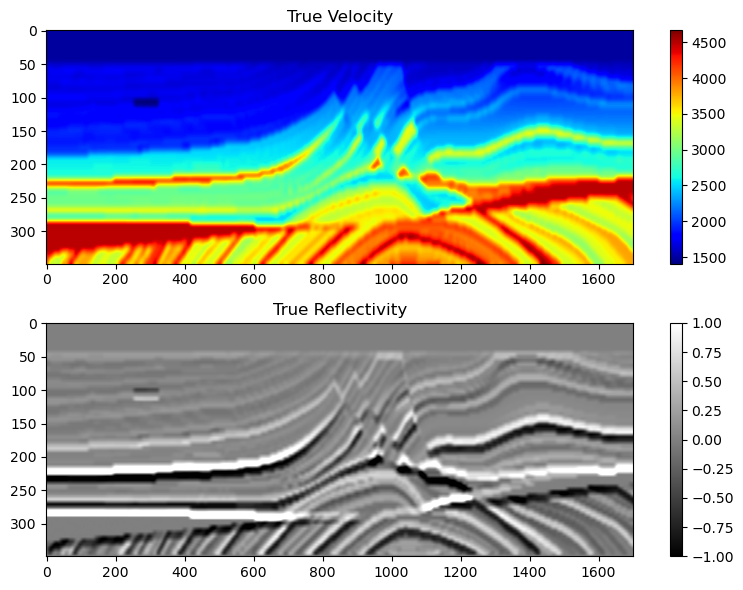

(vmin, vmax, rmax) = (1405.7601f0, 4667.2783f0, 199.77002f0)


In [7]:
vmin,vmax = extrema(v1)
rmax = maximum(abs,r1)
@show vmin,vmax,rmax;
figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity");

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("True Reflectivity");

tight_layout()

## 3. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [8]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [9]:
@everywhere using DistributedArrays, DistributedJets, DistributedOperations, Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra, Schedulers

┌ Info: Precompiling WaveFD [44f9e87b-acd6-44e6-b5b0-e1db9a6b2dd4]
└ @ Base loading.jl:1278

OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '22'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'CLOSE'
  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21},{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
  OMP_STACKSIZE = '0'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '2147483647'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  OMP_DISPLAY_AFFINITY = 'FALSE'
  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
OPENMP DISPLAY ENVIRONMENT END


      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

┌ Info: Precompiling JetPackWaveFD [30ac78e6-0b88-494d-b61b-9674962a0c3e]
└ @ Base loading.jl:1278

OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '22'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'CLOSE'
  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21},{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
  OMP_STACKSIZE = '0'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '2147483647'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  OMP_DISPLAY_AFFINITY = 'FALSE'
  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
OPENMP DISPLAY ENVIRONMENT END


## 4. Create list of shot locations 
We use 100 shot locations, many times than our FWI example, and run at significantly higher frequency. 

In [10]:
nshots = 100
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)));
@show nshots;
@show sx;

nshots = 100
sx = [0, 172, 343, 515, 687, 859, 1030, 1202, 1374, 1545, 1717, 1889, 2061, 2232, 2404, 2576, 2747, 2919, 3091, 3263, 3434, 3606, 3778, 3949, 4121, 4293, 4465, 4636, 4808, 4980, 5152, 5323, 5495, 5667, 5838, 6010, 6182, 6354, 6525, 6697, 6869, 7040, 7212, 7384, 7556, 7727, 7899, 8071, 8242, 8414, 8586, 8758, 8929, 9101, 9273, 9444, 9616, 9788, 9960, 10131, 10303, 10475, 10646, 10818, 10990, 11162, 11333, 11505, 11677, 11848, 12020, 12192, 12364, 12535, 12707, 12879, 13051, 13222, 13394, 13566, 13737, 13909, 14081, 14253, 14424, 14596, 14768, 14939, 15111, 15283, 15455, 15626, 15798, 15970, 16141, 16313, 16485, 16657, 16828, 17000]


## 5. Define the `timemute!`, `migrateshot`, and `stack` functions
* `timemute!` mutes data to remove the direct arrival and refraction
* `migrateshot` runs the migrations for each shot and writes image and illumination files to scratch disk
* `stack` reads in shots from disk and stacks them

**TODO:** convert the IO to use CloudSeis as proxy for cloud storage

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [11]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

#### Global variables for number of samples and sample rate

In [12]:
@everywhere begin
    ntrec = 3501
    dtrec = 0.002
    dtmod = 0.001
    fpeak = 10.0
    tmute = 7.5 / (2 * 10)
end
@show fpeak,tmute

(fpeak, tmute) = (10.0, 0.375)


(10.0, 0.375)

#### Build the `timemute!` function 

In [13]:
@everywhere function timemute!(F, d, watervel, tmute)
    for i = 1:length(state(F, :rx)) 
        rx = state(F, :rx)
        rz = state(F, :rz)
        sx = state(F, :sx)
        sz = state(F, :sz)
        dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
        time = dist / watervel
        tbeg = 1
        tend = round(Int, (time + tmute) / state(F,:dtrec))
        tend = clamp(tend,1,size(d,1))
        d[tbeg:tend,i] .= 0
    end
    nothing
end

#### Build the `migrateshot` function

In [14]:
# notice we model to significantly shorter time than for FWI
@everywhere function migrateshot(isrc,nz,nx,dz,dx,_vtrue,_v,sx)
    F1 = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=fpeak),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        imgcondition = "standard",
        srcfieldfile = joinpath(scratch, "field-$isrc-icstandard-$(randstring()).bin"),
        reportinterval=0)

    F2 = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=fpeak),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        imgcondition = "RTM",
        srcfieldfile = joinpath(scratch, "field-$isrc-icrtm-$(randstring()).bin"),
        reportinterval=0)

    d = F1*localpart(_vtrue) #here we model the data usually you would just read the data
    timemute!(F1,d,1500,tmute) #mute out the direct and diving waves
    J1 = jacobian!(F1, localpart(_v))
    illum = srcillum(J1)

    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid())"
    m1 = J1'*d

    J2 = jacobian!(F2, localpart(_v))
    m2 = J2'*d

    @info "norm(d)=$(norm(d)) norm(mStd)=$(norm(m1)) norm(mRtm)=$(norm(m2))"
    
    #delete scratch files that we don't need anymore
    close(F1) 
    close(F2)

    write(joinpath(scratch,"image1_$(isrc).bin"),m1)
    write(joinpath(scratch,"image2_$(isrc).bin"),m2)
    write(joinpath(scratch,"illum_$(isrc).bin"),illum)
end

#### Build the `stack` function

In [15]:
function stack(shots,nz,nx)
   img1 = zeros(Float32,nz,nx)
   img2 = zeros(Float32,nz,nx)
   ill = zeros(Float32,nz,nx)
   for isrc in shots
      img1 .+= read!(joinpath(scratch,"image1_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      img2 .+= read!(joinpath(scratch,"image2_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      ill .+= read!(joinpath(scratch,"illum_$(isrc).bin"), Array{Float32}(undef,nz,nx));
   end
   return img1,img2,ill
end

stack (generic function with 1 method)

## 6. Run the migration and write individual shot images to disk

We use epmap to schedule the work for the migration.

In [16]:
# broadcast the models to the workers
_v1 = bcast(v1);

In [17]:
t1 = @elapsed begin
    epmap(i->migrateshot(i, nz, nx, dz, dx, _v1, _v1, sx), 1:nshots)
end
@show t1;

┌ Info: running task 1 on process 2; 2 workers total; 99 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
┌ Info: running task 2 on process 3; 2 workers total; 98 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 1 on cbox-wask-HC44rs with id 2
[ Info: migrating shot 2 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=48.480366 norm(mStd)=0.3350104 norm(mRtm)=0.05659647
┌ Info: running task 3 on process 2; 2 workers total; 97 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=49.403656 norm(mStd)=0.39500552 norm(mRtm)=0.06960506
┌ Info: running task 4 on process 3; 2 workers total; 96 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 3 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 4 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=52.58002 norm(mStd)=0.448561 norm(mRtm)=0.08102739
┌ Info: running task 5 on process 2; 2 workers total; 95 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=53.660538 norm(mStd)=0.46175525 norm(mRtm)=0.08404491
┌ Info: running task 6 on process 3; 2 workers total; 94 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 5 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 6 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=51.44853 norm(mStd)=0.42297453 norm(mRtm)=0.07581231
┌ Info: running task 7 on process 2; 2 workers total; 93 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=49.83811 norm(mStd)=0.39038056 norm(mRtm)=0.06988242
┌ Info: running task 8 on process 3; 2 workers total; 92 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 7 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 8 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=49.680035 norm(mStd)=0.38644284 norm(mRtm)=0.06973775
┌ Info: running task 9 on process 2; 2 workers total; 91 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=50.018383 norm(mStd)=0.39937 norm(mRtm)=0.07168472
┌ Info: running task 10 on process 3; 2 workers total; 90 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 9 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 10 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=49.632282 norm(mStd)=0.38614258 norm(mRtm)=0.06846001
[ Info: norm(d)=50.87973 norm(mStd)=0.41000322 norm(mRtm)=0.07252838
┌ Info: running task 11 on process 2; 2 workers total; 89 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
┌ Info: running task 12 on process 3; 2 workers total; 88 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 11 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 12 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=61.700962 norm(mStd)=0.5438323 norm(mRtm)=0.104580656
┌ Info: running task 13 on process 3; 2 workers total; 87 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=58.932575 norm(mStd)=0.53256035 norm(mRtm)=0.10029463
┌ Info: running task 14 on process 2; 2 workers total; 86 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 13 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 14 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=58.23071 norm(mStd)=0.46074778 norm(mRtm)=0.088034056
┌ Info: running task 15 on process 3; 2 workers total; 85 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=56.74115 norm(mStd)=0.44480845 norm(mRtm)=0.08432879
┌ Info: running task 16 on process 2; 2 workers total; 84 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 15 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 16 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=53.867237 norm(mStd)=0.40287718 norm(mRtm)=0.0761995
┌ Info: running task 17 on process 3; 2 workers total; 83 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=52.6701 norm(mStd)=0.38832325 norm(mRtm)=0.07378345
┌ Info: running task 18 on process 2; 2 workers total; 82 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 17 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 18 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=52.082775 norm(mStd)=0.37044853 norm(mRtm)=0.06998091
┌ Info: running task 19 on process 3; 2 workers total; 81 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=51.704525 norm(mStd)=0.3502981 norm(mRtm)=0.06660389
┌ Info: running task 20 on process 2; 2 workers total; 80 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 19 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 20 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=54.742466 norm(mStd)=0.3830619 norm(mRtm)=0.07488031
┌ Info: running task 21 on process 3; 2 workers total; 79 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=58.17876 norm(mStd)=0.4080633 norm(mRtm)=0.08182599
┌ Info: running task 22 on process 2; 2 workers total; 78 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 21 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 22 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=63.004272 norm(mStd)=0.46724504 norm(mRtm)=0.096790574
┌ Info: running task 23 on process 3; 2 workers total; 77 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=63.931057 norm(mStd)=0.502792 norm(mRtm)=0.10365442
┌ Info: running task 24 on process 2; 2 workers total; 76 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 23 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 24 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=63.31475 norm(mStd)=0.5011194 norm(mRtm)=0.10336717
┌ Info: running task 25 on process 3; 2 workers total; 75 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=62.0951 norm(mStd)=0.45626426 norm(mRtm)=0.09597413
┌ Info: running task 26 on process 2; 2 workers total; 74 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 25 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 26 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=62.616676 norm(mStd)=0.43472806 norm(mRtm)=0.09329665
┌ Info: running task 27 on process 3; 2 workers total; 73 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 27 on cbox-wask-HC44rs with id 3
[ Info: norm(d)=65.247314 norm(mStd)=0.47008193 norm(mRtm)=0.10032556
┌ Info: running task 28 on process 2; 2 workers total; 72 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 28 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=67.51088 norm(mStd)=0.50443894 norm(mRtm)=0.107729234
┌ Info: running task 29 on process 3; 2 workers total; 71 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 29 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=68.33277 norm(mStd)=0.520058 norm(mRtm)=0.110398896
┌ Info: running task 30 on process 2; 2 workers total; 70 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 30 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=70.88289 norm(mStd)=0.5619161 norm(mRtm)=0.11987896
┌ Info: running task 31 on process 3; 2 workers total; 69 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 31 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=71.91391 norm(mStd)=0.5757659 norm(mRtm)=0.124147214
┌ Info: running task 32 on process 2; 2 workers total; 68 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 32 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=70.799866 norm(mStd)=0.55413723 norm(mRtm)=0.11918157
┌ Info: running task 33 on process 3; 2 workers total; 67 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 33 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=67.487656 norm(mStd)=0.50597274 norm(mRtm)=0.10611047
┌ Info: running task 34 on process 2; 2 workers total; 66 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 34 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=65.37824 norm(mStd)=0.4768974 norm(mRtm)=0.09925762
┌ Info: running task 35 on process 3; 2 workers total; 65 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 35 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=62.5874 norm(mStd)=0.45192704 norm(mRtm)=0.09259399
┌ Info: running task 36 on process 2; 2 workers total; 64 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 36 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=60.221977 norm(mStd)=0.43145117 norm(mRtm)=0.08631013
┌ Info: running task 37 on process 3; 2 workers total; 63 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 37 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=60.107216 norm(mStd)=0.43707502 norm(mRtm)=0.08658014
┌ Info: running task 38 on process 2; 2 workers total; 62 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 38 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=61.57384 norm(mStd)=0.46095836 norm(mRtm)=0.09263683
┌ Info: running task 39 on process 3; 2 workers total; 61 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 39 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=62.41645 norm(mStd)=0.491084 norm(mRtm)=0.0975172
┌ Info: running task 40 on process 2; 2 workers total; 60 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 40 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=60.74578 norm(mStd)=0.48060513 norm(mRtm)=0.09071905
┌ Info: running task 41 on process 3; 2 workers total; 59 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 41 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=58.659145 norm(mStd)=0.44871154 norm(mRtm)=0.08458201
┌ Info: running task 42 on process 2; 2 workers total; 58 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 42 on cbox-wask-HC44rs with id 2
[ Info: norm(d)=59.50196 norm(mStd)=0.44703063 norm(mRtm)=0.08714267
┌ Info: running task 43 on process 3; 2 workers total; 57 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 43 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=62.606705 norm(mStd)=0.4855664 norm(mRtm)=0.09688672
┌ Info: running task 44 on process 2; 2 workers total; 56 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 44 on cbox-wask-HC44rs with id 2
[ Info: norm(d)=61.346027 norm(mStd)=0.47591695 norm(mRtm)=0.09302256
┌ Info: running task 45 on process 3; 2 workers total; 55 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 45 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=59.023933 norm(mStd)=0.45690158 norm(mRtm)=0.08722515
┌ Info: running task 46 on process 2; 2 workers total; 54 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=61.734234 norm(mStd)=0.5103342 norm(mRtm)=0.09954845
┌ Info: running task 47 on process 3; 2 workers total; 53 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 46 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 47 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=65.5436 norm(mStd)=0.574058 norm(mRtm)=0.11405001
┌ Info: running task 48 on process 2; 2 workers total; 52 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=68.07857 norm(mStd)=0.6285534 norm(mRtm)=0.12402703
┌ Info: running task 49 on process 3; 2 workers total; 51 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 48 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 49 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=64.11361 norm(mStd)=0.5886111 norm(mRtm)=0.11257955
┌ Info: running task 50 on process 2; 2 workers total; 50 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=59.75897 norm(mStd)=0.5273819 norm(mRtm)=0.10202031
┌ Info: running task 51 on process 3; 2 workers total; 49 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 50 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 51 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=54.37389 norm(mStd)=0.44113147 norm(mRtm)=0.0832483
┌ Info: running task 52 on process 2; 2 workers total; 48 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=52.408466 norm(mStd)=0.46369627 norm(mRtm)=0.08560974
┌ Info: running task 53 on process 3; 2 workers total; 47 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 52 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 53 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=42.682144 norm(mStd)=0.24277472 norm(mRtm)=0.054538533
┌ Info: running task 54 on process 2; 2 workers total; 46 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=46.647854 norm(mStd)=0.31507403 norm(mRtm)=0.06998651
┌ Info: running task 55 on process 3; 2 workers total; 45 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 54 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 55 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=37.54539 norm(mStd)=0.18928486 norm(mRtm)=0.03938689
┌ Info: running task 56 on process 2; 2 workers total; 44 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=38.33886 norm(mStd)=0.17763539 norm(mRtm)=0.04085495
┌ Info: running task 57 on process 3; 2 workers total; 43 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 56 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 57 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=37.11091 norm(mStd)=0.18605514 norm(mRtm)=0.04155799
┌ Info: running task 58 on process 2; 2 workers total; 42 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=44.263172 norm(mStd)=0.30776694 norm(mRtm)=0.06516566
┌ Info: running task 59 on process 3; 2 workers total; 41 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 58 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 59 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=46.17396 norm(mStd)=0.32738623 norm(mRtm)=0.07443248
┌ Info: running task 60 on process 2; 2 workers total; 40 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=51.478325 norm(mStd)=0.4420462 norm(mRtm)=0.09672531
┌ Info: running task 61 on process 3; 2 workers total; 39 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 60 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 61 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=46.693542 norm(mStd)=0.27505723 norm(mRtm)=0.060255997
┌ Info: running task 62 on process 3; 2 workers total; 38 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=39.192635 norm(mStd)=0.17931856 norm(mRtm)=0.04381968
┌ Info: running task 63 on process 2; 2 workers total; 37 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 62 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 63 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=52.003468 norm(mStd)=0.31624943 norm(mRtm)=0.07139993
┌ Info: running task 64 on process 3; 2 workers total; 36 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=57.487675 norm(mStd)=0.380774 norm(mRtm)=0.085810944
┌ Info: running task 65 on process 2; 2 workers total; 35 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 64 on cbox-wask-HC44rs with id 3


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 65 on cbox-wask-HC44rs with id 2


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=51.195133 norm(mStd)=0.30242142 norm(mRtm)=0.06794482
┌ Info: running task 66 on process 3; 2 workers total; 34 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=47.876453 norm(mStd)=0.26397848 norm(mRtm)=0.06194052
┌ Info: running task 67 on process 2; 2 workers total; 33 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 66 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 67 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=46.46747 norm(mStd)=0.23357782 norm(mRtm)=0.058823213
┌ Info: running task 68 on process 3; 2 workers total; 32 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=41.86844 norm(mStd)=0.1787553 norm(mRtm)=0.04532753
┌ Info: running task 69 on process 2; 2 workers total; 31 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 68 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 69 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=40.83596 norm(mStd)=0.17821734 norm(mRtm)=0.043011196
┌ Info: running task 70 on process 3; 2 workers total; 30 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=41.18586 norm(mStd)=0.17227139 norm(mRtm)=0.04225022
┌ Info: running task 71 on process 2; 2 workers total; 29 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 70 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 71 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=43.36584 norm(mStd)=0.20017843 norm(mRtm)=0.050443344
┌ Info: running task 72 on process 3; 2 workers total; 28 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=46.749603 norm(mStd)=0.25361001 norm(mRtm)=0.062591486
┌ Info: running task 73 on process 2; 2 workers total; 27 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 72 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 73 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=49.344097 norm(mStd)=0.29854786 norm(mRtm)=0.06974741
┌ Info: running task 74 on process 3; 2 workers total; 26 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=51.5119 norm(mStd)=0.3514448 norm(mRtm)=0.07225086
┌ Info: running task 75 on process 2; 2 workers total; 25 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 74 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 75 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=49.279125 norm(mStd)=0.31784922 norm(mRtm)=0.06496659
┌ Info: running task 76 on process 3; 2 workers total; 24 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=48.43695 norm(mStd)=0.2881805 norm(mRtm)=0.06558872
┌ Info: running task 77 on process 2; 2 workers total; 23 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 76 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 77 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=51.689697 norm(mStd)=0.35499272 norm(mRtm)=0.07758785
┌ Info: running task 78 on process 3; 2 workers total; 22 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 78 on cbox-wask-HC44rs with id 3
[ Info: norm(d)=54.88798 norm(mStd)=0.4213722 norm(mRtm)=0.08463945
┌ Info: running task 79 on process 2; 2 workers total; 21 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 79 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=45.088985 norm(mStd)=0.27563706 norm(mRtm)=0.052297797
┌ Info: running task 80 on process 3; 2 workers total; 20 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 80 on cbox-wask-HC44rs with id 3
[ Info: norm(d)=42.89764 norm(mStd)=0.2203206 norm(mRtm)=0.043874975
┌ Info: running task 81 on process 2; 2 workers total; 19 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 81 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=46.832275 norm(mStd)=0.26512486 norm(mRtm)=0.05122923
┌ Info: running task 82 on process 3; 2 workers total; 18 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 82 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=53.3149 norm(mStd)=0.35893983 norm(mRtm)=0.06943919
┌ Info: running task 83 on process 2; 2 workers total; 17 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 83 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=55.342194 norm(mStd)=0.39620945 norm(mRtm)=0.078433424
┌ Info: running task 84 on process 3; 2 workers total; 16 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 84 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=46.187042 norm(mStd)=0.25996184 norm(mRtm)=0.054348294
┌ Info: running task 85 on process 2; 2 workers total; 15 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 85 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=45.320988 norm(mStd)=0.24617381 norm(mRtm)=0.052746583
┌ Info: running task 86 on process 3; 2 workers total; 14 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 86 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=41.606205 norm(mStd)=0.20557946 norm(mRtm)=0.04482072
┌ Info: running task 87 on process 2; 2 workers total; 13 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 87 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=40.539997 norm(mStd)=0.20407175 norm(mRtm)=0.043450303
┌ Info: running task 88 on process 3; 2 workers total; 12 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 88 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=39.52625 norm(mStd)=0.19618392 norm(mRtm)=0.041621972
┌ Info: running task 89 on process 2; 2 workers total; 11 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 89 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=38.13563 norm(mStd)=0.18969889 norm(mRtm)=0.04240411
┌ Info: running task 90 on process 3; 2 workers total; 10 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 90 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=40.0987 norm(mStd)=0.21510087 norm(mRtm)=0.046962827
┌ Info: running task 91 on process 2; 2 workers total; 9 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 91 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=36.61977 norm(mStd)=0.17371666 norm(mRtm)=0.04204656
┌ Info: running task 92 on process 3; 2 workers total; 8 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 92 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=35.30106 norm(mStd)=0.17162064 norm(mRtm)=0.03759985
┌ Info: running task 93 on process 2; 2 workers total; 7 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 93 on cbox-wask-HC44rs with id 2
[ Info: norm(d)=34.778004 norm(mStd)=0.17164893 norm(mRtm)=0.033170946
┌ Info: running task 94 on process 3; 2 workers total; 6 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 94 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=34.474632 norm(mStd)=0.17580937 norm(mRtm)=0.032606117
┌ Info: running task 95 on process 2; 2 workers total; 5 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 95 on cbox-wask-HC44rs with id 2
[ Info: norm(d)=33.878567 norm(mStd)=0.17234488 norm(mRtm)=0.031657577
┌ Info: running task 96 on process 3; 2 workers total; 4 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 96 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=34.180923 norm(mStd)=0.1757877 norm(mRtm)=0.032330908
┌ Info: running task 97 on process 2; 2 workers total; 3 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=35.397743 norm(mStd)=0.18994217 norm(mRtm)=0.036170308
┌ Info: running task 98 on process 3; 2 workers total; 2 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 97 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 98 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=35.267776 norm(mStd)=0.18571128 norm(mRtm)=0.035365395
┌ Info: running task 99 on process 2; 2 workers total; 1 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: norm(d)=37.612755 norm(mStd)=0.22288734 norm(mRtm)=0.0428314
┌ Info: running task 100 on process 3; 2 workers total; 0 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 99 on cbox-wask-HC44rs with id 2


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


[ Info: migrating shot 100 on cbox-wask-HC44rs with id 3


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionWaveFieldSeparationRTM()


[ Info: norm(d)=36.704765 norm(mStd)=0.21702214 norm(mRtm)=0.040770363
[ Info: norm(d)=36.440582 norm(mStd)=0.18531483 norm(mRtm)=0.035945624


t1 = 2952.764997832


In [18]:
@printf("Time for migrating %.2f minutes\n", t1 / 60)

Time for migrating 49.21 minutes


## 7. Stack the individual shot images 

In [19]:
shots = collect(1:nshots)
m1, m2, illum1 = stack(shots,nz,nx);
@show extrema(m1)
@show extrema(m2)
@show extrema(illum1)

extrema(m1) = (-0.17269321f0, 0.101530254f0)
extrema(m2) = (-0.03737817f0, 0.039594784f0)
extrema(illum1) = (468.46707f0, 35259.574f0)


(468.46707f0, 35259.574f0)

## 8. Perform a little post migration processing

#### Laplacian filter to remove backscattered noise

In [20]:
L = JopHighpass(JetSpace(Float32,nz,nx), nit=(1,1))

"Jet linear operator, (349, 1701) → (349, 1701)"

#### Apply low cut filter, illumination compensation, and gain

In [21]:
g = ([0:(nz-1);]) * ones(Float32,1,nx);
I = g ./ (illum1 .+ 1f-8 * maximum(abs, illum1));

m1 .*= I;
m2 .*= I;

img1 = L * (I .* m1);
img2 = L * (I .* m2);

#### Apply water bottom mute

In [22]:
m1[v1_orig.==1500.0] .= 0;
m2[v1_orig.==1500.0] .= 0;

img1[v1_orig.==1500.0] .= 0;
img2[v1_orig.==1500.0] .= 0;

## 9. Visualize Results

#### Show the raw images
Note that you can see backscattered energy in the top of the raw standard imaging condition result below that is not present in the raw wavefield sepaaration imaging condition result. 

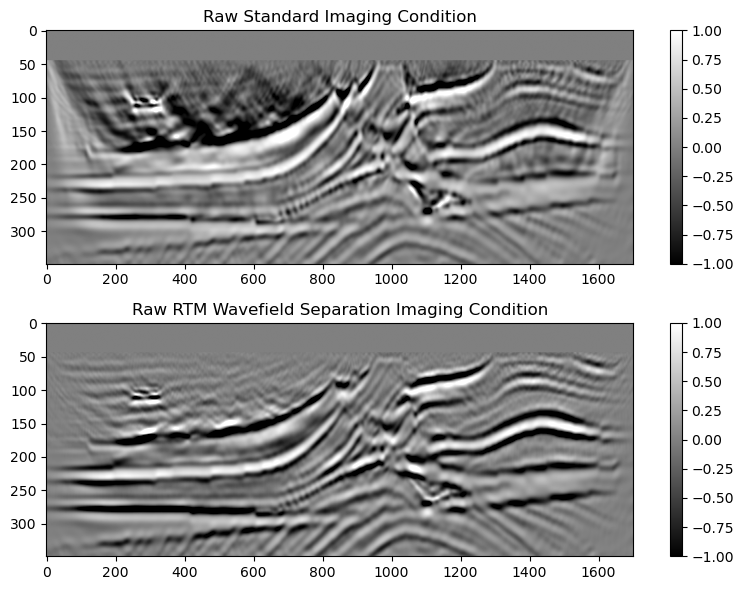

In [23]:
mrms1 = 2.5 * sqrt(norm(m1)^2 / length(m1))
mrms2 = 2.5 * sqrt(norm(m2)^2 / length(m2))

figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(m1 ./ mrms1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Raw Standard Imaging Condition")

subplot(2,1,2); imshow(m2 ./ mrms2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Raw RTM Wavefield Separation Imaging Condition")

tight_layout()

#### Show the filtered images

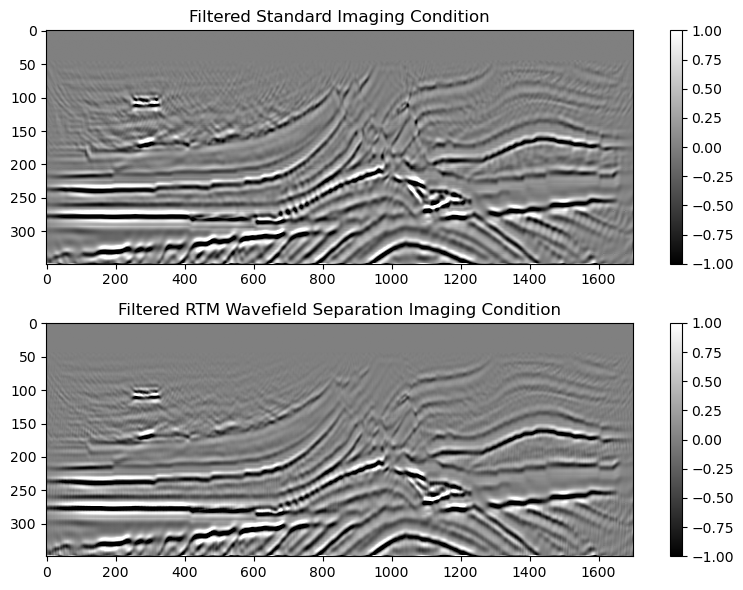

In [24]:
irms1 = 2.5 * sqrt(norm(img1)^2 / length(img1))
irms2 = 2.5 * sqrt(norm(img2)^2 / length(img2))

figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(img1 ./ irms1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Filtered Standard Imaging Condition")

subplot(2,1,2); imshow(img2 ./ irms2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Filtered RTM Wavefield Separation Imaging Condition")

tight_layout()

## Remove workers

In [25]:
# rmprocs(workers())

## Delete scratch files

In [26]:
# for isrc in shots
#   rm(joinpath(scratch,"image1_$(isrc).bin"))
#   rm(joinpath(scratch,"image2_$(isrc).bin"))
#   rm(joinpath(scratch,"illum_$(isrc).bin"))
# end

In [27]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 49.98 minutes\n"